# Fit regression models of seal abundance and presence
This notebook uses the information on the estimated number of seals per 5 x 5 KM grid cell to build regression models that aim to explain some of the factors that explain the observed distribution and abundance of Weddell seals around Antarctica.

Run this file every time you run the notebook "Attribute geospatial data with seal abundance data", as it means you have new geospatial covariates to analyze.

### Loading the required libraries and other dependencies

In [1]:
## Clear memory
rm(list=ls())
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,511929,27.4,940480,50.3,750400,40.1
Vcells,931865,7.2,1650153,12.6,1081468,8.3


In [6]:
libs<-c("ggplot2","plyr","dplyr","sp","rgeos","raster","rgdal")
lapply(libs, require, character.only = TRUE)
pathToLocalGit<-"/home/ubuntu/Workspace/ContinentalWESEestimates/"

## Load the source utility functions file
source(file=paste0(pathToLocalGit,"scripts/fitRegressionModels_functions.R"))

## load the WESE grid data
load(file=paste0(pathToLocalGit,"data/continentalWESE.RData"))
head(wesedf)

dataproj<-"+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

,gridCellId,meanslope,meanbathy,slope,bathy,shoredist,glacierdist,nearLineId,near_x,near_y,⋯,adpecol,empedist,empecol,cont300dist,cont800dist,coords.x1,coords.x2,mdlCol,mdlIsl,hasMaps
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,68791,2.621992,-2846.908,2.5563672,-2864.911,206728.3,247849.6,2351,-2273383,2327082,⋯,Ferrier Peninsula,1013124,Snow Hill Island,142791.6,588996.1,-2191000,2511000,0,0,0
2,68792,4.591249,-2587.330,4.4836812,-2612.724,208790.2,250334.0,2351,-2273383,2327082,⋯,Ferrier Peninsula,1014024,Snow Hill Island,142791.6,588996.1,-2186000,2511000,0,0,0
3,68819,1.411659,-3014.080,1.5170590,-3024.577,200154.1,241050.2,2351,-2273383,2327082,⋯,Ferrier Peninsula,1007323,Snow Hill Island,138016.9,584654.8,-2196000,2506000,0,0,0
4,68820,1.413779,-2920.630,0.7565953,-2930.036,202161.9,243501.3,2351,-2273383,2327082,⋯,Ferrier Peninsula,1008204,Snow Hill Island,138016.9,584654.8,-2191000,2506000,0,0,0
5,68821,4.561732,-2686.220,4.5623317,-2716.875,204263.8,246029.6,2351,-2273383,2327082,⋯,Ferrier Peninsula,1009109,Snow Hill Island,138016.9,584654.8,-2186000,2506000,0,0,0
6,68822,4.902608,-2264.930,5.1146288,-2277.257,206460.4,248632.8,2351,-2273383,2327082,⋯,Ferrier Peninsula,1010037,Snow Hill Island,138016.9,584654.8,-2181000,2506000,0,0,0


## Regresion analysis preliminaries

The above tble (wesedf) is ready for fitting regression models, but first we will need the following:
1. Be able to extend the attribution of the table with geospatial hypotheses (e.g., David's WESE zones vs. Michelle's WESE zones)
2. Generate N samples of "no-seal" locations of identical size as the number of grid cells with WESE presence
3. Be able to compute a linear model with the set of N bootstrap samples, and have it summarized for us
  
### On the above needs
__Regarding #1__ it is done with the functions "readShapeFile" and "attributeWithShape". The first function reads the shape file into a spatial object and the second one uses information on the spatial object (e.g., David's WESE zones) into the data.  
Here's an example to load a point shapefile, from an example copied into the repository's data folder:

OGR data source with driver: ESRI Shapefile 
Source: "/home/ubuntu/Workspace/ContinentalWESEestimates/data/glaciers", layer: "glaciers"
with 1499 features
It has 69 fields
Integer64 fields read as strings:  objectid gaz_id scar_commo coordinate altitude_a max_digita location_m country_id 


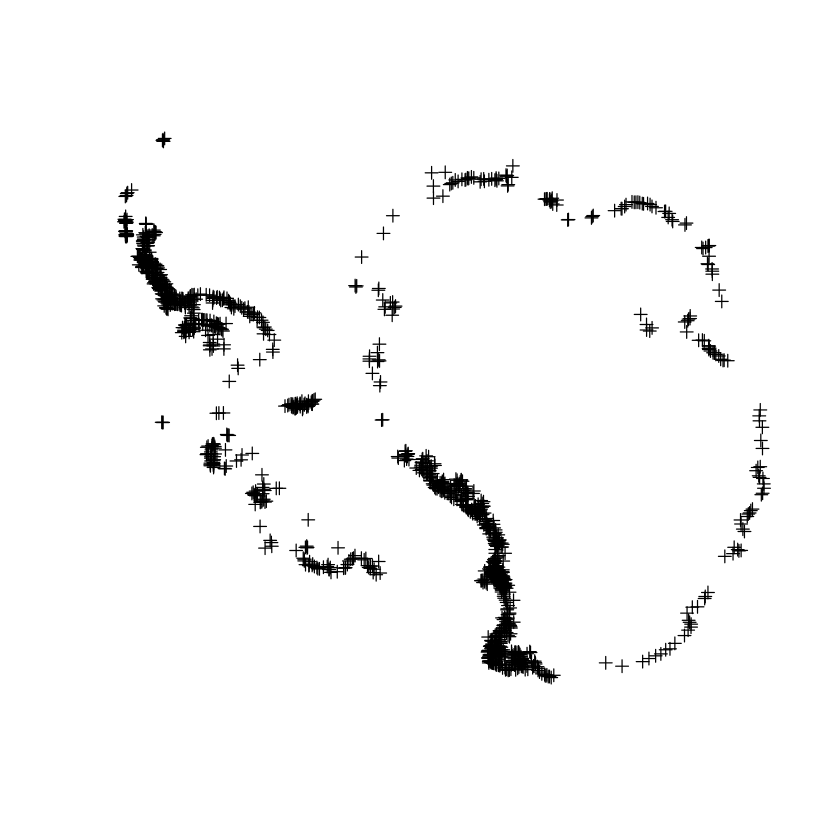

In [7]:
icebergs<-readShapeFile(pathToGit=pathToLocalGit,folderName="glaciers",shapeName="glaciers")
#folderName is the folder name in the workspace, and shapeName is the name of the .shp file
plot(icebergs)

We could (but we don't because this is a point shapefile, not a polygon shapefile) use the spatial object "icebergs" ploted above to attribute wesedf with some information in it. We can see the contents of "icebergs" with a head:

In [8]:
head(icebergs)

,objectid,fid_,place_name,place_na_1,gaz_id,country_na,latitude,longitude,altitude,feature_ty,⋯,max_digita,location_m,metadata_e,survey_sta,satellite_,online_dis,geometry,reason,relic_flag,country_id
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,59283,NA,Aagaard Glacier,Aagaard Glacier,121528,United States of America,-66.7667,-64.5167,0,Glacier,⋯,0,0,NA,NA,NA,NA,POINT (-64.516667 -66.766667),NA,No,840
2,59285,NA,Aaron Glacier,Aaron Glacier,121530,United States of America,-85.1333,-90.6667,0,Glacier,⋯,0,0,NA,NA,NA,NA,POINT (-90.666667 -85.133333),NA,No,840
3,59308,NA,Academy Glacier,Academy Glacier,121553,United States of America,-84.2500,-61.0000,0,Glacier,⋯,0,0,NA,NA,NA,NA,POINT (-61 -84.25),NA,No,840
4,59329,NA,Adams Glacier,Adams Glacier,121575,United States of America,-66.8333,109.6667,0,Glacier,⋯,0,0,NA,NA,NA,NA,POINT (109.666667 -66.833333),NA,No,840
5,59330,NA,Adams Glacier,Adams Glacier,121576,United States of America,-78.1167,163.6333,0,Glacier,⋯,0,0,NA,NA,NA,NA,POINT (163.633333 -78.116667),NA,No,840
6,59364,NA,Aeronaut Glacier,Aeronaut Glacier,121611,United States of America,-73.2667,163.6000,0,Glacier,⋯,0,0,NA,NA,NA,NA,POINT (163.6 -73.266667),NA,No,840


So, we could attribute the wesedf table with the parameter "place_name", like so:

In [ ]:
## DO NOT RUN
## wesedf2<-attributeWithShape(shpobj=icebergs,attribName="place_name",data=wesedf,datKey="gridCellId",
##                              lonfld="coords.x1",latfld="coords.x2",dataproj=dataproj)

If we executed the above example, the resulting table wesedf2 will have a new field called "place_name."

__Regarding #2__ we use the function "bootSampleWESEdata". This function by default generates 100 bootstrap samples (but change with the parameter "nsamples") and returns a list object. Each element of the list is one of the samples. Each sample is a table like wesedf, but it contains an equal number of grids with seals and no seals.  
  
The wesedf table has a column called "hasMaps" to indicate cells with maps, even if these wereeventually estimated to have 0 seals. The function "bootSampleWESEdata" can treat these as if they had no seals, or as if they did. You may indicate the behavior with the parameter "hasMapsBehavior". Set the parameter to 0 (this is the default behavior) to treat these cells as if there are no seals there, or 1 otherwise.

Lastly, we my want to stratify the sample by bins of any one or two (but no more) of the variables in wesedf. To do so, we use the parameter "strtifyByBins". This parameter is a json string that looks like this (for a 2-parameter stratification):  
    "[{"field":"empedist","numbins":3},{"field":"cont800dist","numbins":4}]"  
    
The above string will create 3 equally spaced strata from the values in empedist, and 4 from the values in cont800dist. It will then stratify the random sample such that it includes an even number of values in each of the bins of empedist and cont800dist.  
For example:

In [9]:
names(wesedf)

[1] "gridCellId"  "meanslope"   "meanbathy"   "slope"       "bathy"      
 [6] "shoredist"   "glacierdist" "nearLineId"  "near_x"      "near_y"     
[11] "distToShore" "adpedist"    "adpecol"     "empedist"    "empecol"    
[16] "cont300dist" "cont800dist" "coords.x1"   "coords.x2"   "mdlCol"     
[21] "mdlIsl"      "hasMaps"

In [ ]:
dataList<-bootSampleWESEdata(data=wesedf,nsamples=100,hasMapsBehavior=0,stratifyByBins="[{"field":"empedist","numbins":3}]")

In [ ]:
## The above is ready for fitting regression models, but first 
##we'd like to generate a sample of "no-seal" locations of identical size
# Also show example of how to attribute with shapefile